## Ongoing Notes:
Key Problems:
1. Which dataset or datasets even contain the information we want
2. How do we determine when measurements were taken in the WQP dataset
3. How do we determine which param_codes to use (there are ~10,000!) via NWIS
4. How do we match streamflow gauges to their closest water quality gauge if one exists (lat/long data is available)
5. How do we work with the extremely reduced number of sites that have these niche water quality metrics<br>
    -Seems very unlikely that most if any sites will have all the ones listed in the proposal in one place

...in other words how do we spatially and temporarily match streamflow data with water quality data
<br><br>

TODO:
1. Determine relevant gauge counts for at least some of these metrics, per state
2. Determine type of data returned, time-series, or otherwise
<br><br>

Comments:<br>
How granular will the water quality data be ultimately? Is building a robust water quality profile for a few gauges in locations where EAR is viable the focus, or is having a general idea of an entire watershed regions water quality the focus?

## Initial Water Quality Data Exploration

In [1]:
#Python3.10
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import contextily as cx
from importlib import reload
from typing import IO
from IPython.display import display
from collections import Counter
import warnings
import re

from datetime import datetime, timedelta

# USGS Data retreival tool
from dataretrieval import nwis, utils, codes

# Custom modules are imported in multiple locations to faciliate easy reloading when edits are made to their respective files
import Src.classes as cl
import Src.func as fn
reload(cl)
reload(fn)

# TODO: Look into the warning that this is disabling. It doesn't appear to be significant for the purposes of this code but should be understood
pd.options.mode.chained_assignment = None

#pd.options.mode.chained_assignment = 'warn'

In [2]:
#'01578310'
test_aquifer = 'Central Valley aquifer system'

df_sites = pd.read_excel('Prelim_Data/National_Metrics/National_Metrics_30_90.xlsx', sheet_name='site_metrics', dtype=fn.DATASET_DTYPES)
df_sites = df_sites.dropna(subset=['within_aq'])
print(len(df_sites))

3312


In [50]:
from dataretrieval import wqp
df, metadata = wqp.get_results(siteid='USGS-11447650', startDateLo='10-01-1990', startDateHi='09-30-2020', providers="NWIS", legacy=True)

C:\Users\kondris\AppData\Local\anaconda3\envs\EPA_EAR_Project\lib\site-packages\dataretrieval\wqp.py:549: UserWarning: USGS discrete water quality data availability and format are changing. Beginning in March 2024 the data obtained from legacy profiles will not include new USGS data or recent updates to existing data. To view the status of changes in data availability and code functionality, visit: https://doi-usgs.github.io/dataRetrieval/articles/Status.html. If you have additional questions about these changes, email CompTools@usgs.gov.
  warnings.warn(
C:\Users\kondris\AppData\Local\anaconda3\envs\EPA_EAR_Project\lib\site-packages\dataretrieval\wqp.py:96: DtypeWarning: Columns (13,19,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=',')


In [52]:
df['USGSPCode'].head()

0     10
1     25
2     95
3    191
4    300
Name: USGSPCode, dtype: int64

In [103]:
#param_meta = param_meta.drop_duplicates(subset='USGSPCode').set_index('USGSPCode')
param_meta

duplicate_rows = param_meta[param_meta.duplicated(subset='USGSPCode', keep=False)]
duplicate_rows

#print("Unique USGSPCode in param_meta:", param_meta.index.nunique())
#print("Unique codes in pivot_df columns:", len(pivot_df.columns))
#param_meta.index.duplicated().sum()

,USGSPCode,CharacteristicName,ResultMeasure/MeasureUnitCode
0,10,"Temperature, water",deg C
1,25,Barometric pressure,mm/Hg
2,95,Specific conductance,uS/cm @25C
3,191,"Acidity, (H+)",mg/l
4,300,Oxygen,mg/l
...,...,...,...
87956,70331,Suspended Sediment Concentration (SSC),%
87957,80154,Suspended Sediment Concentration (SSC),mg/l
87958,91157,Sediment,g
87959,91158,Sediment,g


In [80]:
duplicated_codes = param_meta.index[param_meta.index.duplicated()].unique()
print(f"{len(duplicated_codes)} USGSPCodes have multiple entries in param_meta.")

0 USGSPCodes have multiple entries in param_meta.


In [96]:
df['datetime'] = pd.to_datetime(df['ActivityStartDate'].astype(str) + ' ' + df['ActivityStartTime/Time'].astype(str))
df['USGSPCode'] = df['USGSPCode'].astype(str)
print(df['USGSPCode'].dtype)

# Pivot the DataFrame
pivot_df = df.pivot_table(
    index='datetime',
    columns='USGSPCode',
    #columns='CharacteristicName',
    values='ResultMeasureValue',
    aggfunc='first'  # or 'mean', 'max', etc., if duplicates exist
)

# Get mapping from code → name and unit
# Drop duplicates to ensure clean mapping
param_meta = df[['USGSPCode', 'CharacteristicName', 'ResultMeasure/MeasureUnitCode']]

#param_meta = param_meta.drop_duplicates(subset='USGSPCode').set_index('USGSPCode')

# # Create a MultiIndex for the columns
# new_columns = pd.MultiIndex.from_tuples([
#     (
#         code,
#         param_meta.loc[code, 'CharacteristicName'] if code in param_meta.index else '',
#         param_meta.loc[code, 'ResultMeasure/MeasureUnitCode'] if code in param_meta.index else ''
#     )
#     for code in pivot_df.columns
# ], names=['Parameter Code', 'Characteristic', 'Unit'])

# # Result: one row per date+time, parameter codes as columns, values filled in
pivot_df.head(5)

object


USGSPCode,10,1000,1005,1020,1030,1040,1046,1056,1060,1065,...,940,945,95,950,9511,955,99430,99835,99994,99995
datetime,,,,,,,,,,,,,,,,,,,,,
1990-12-12 09:55:00,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-12-12 10:00:00,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,132.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-12-12 10:06:00,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,131.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-12-12 10:11:00,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,131.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-12-12 10:15:00,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,131.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
print("Unique USGSPCode in param_meta:", param_meta.index.nunique())
print("Unique codes in pivot_df columns:", len(pivot_df.columns))

missing_codes = set(pivot_df.columns) - set(param_meta.index)
print(f"Missing codes in param_meta: {len(missing_codes)}")

param_meta = param_meta.drop_duplicates(subset='USGSPCode')

duplicate_rows = param_meta[param_meta.duplicated(subset='USGSPCode', keep=False)]
print(duplicate_rows)

param_meta_check = param_meta.loc[pivot_df.columns, ['CharacteristicName', 'ResultMeasure/MeasureUnitCode']]
print(param_meta_check)

Unique USGSPCode in param_meta: 848
Unique codes in pivot_df columns: 449
Missing codes in param_meta: 449
Empty DataFrame
Columns: [USGSPCode, CharacteristicName, ResultMeasure/MeasureUnitCode]
Index: []


KeyError: "None of [Index(['10', '1000', '1005', '1020', '1030', '1040', '1046', '1056', '1060',\n       '1065',\n       ...\n       '940', '945', '95', '950', '9511', '955', '99430', '99835', '99994',\n       '99995'],\n      dtype='object', name='USGSPCode', length=449)] are in the [index]"

In [5]:
df.to_csv('water_quality/srb_waterquality.csv')

In [12]:
#counted_sites

In [7]:
site_list = df_sites['site_no'].to_list()
counted_sites = []
counter = Counter()

for site in site_list:
    try:
        print(f'Trying site: {site}')
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            df, metadata = nwis.get_qwdata(sites=site, start='1990-10-01', end='2020-09-30')            
            counter.update(df.columns)
            counted_sites.append(site)
            
    except Exception as e:
        print(f'ERROR: {site} - {e}')   
        
print(counter)
print(f'Total Sites: {len(counted_sites)}')

Trying site: 02339495
ERROR: 02339495 - No sites/data found using the selection criteria specified in url: https://nwis.waterdata.usgs.gov/nwis/qwdata?site_no=02339495&begin_date=1990-10-01&end_date=2020-09-30&qw_sample_wide=qw_sample_wide&agency_cd=USGS&format=rdb&pm_cd_compare=Greater+than&inventory_output=0&rdb_inventory_output=file&TZoutput=0&rdb_qw_attributes=expanded&date_format=YYYY-MM-DD&rdb_compression=value&submitted_form=brief_list
Trying site: 02342500
Trying site: 02361000
Trying site: 02361500
Trying site: 02363000
Trying site: 02364500
Trying site: 02369800
Trying site: 02371500
Trying site: 02372250
Trying site: 02372422
Trying site: 02372430
ERROR: 02372430 - No sites/data found using the selection criteria specified in url: https://nwis.waterdata.usgs.gov/nwis/qwdata?site_no=02372430&begin_date=1990-10-01&end_date=2020-09-30&qw_sample_wide=qw_sample_wide&agency_cd=USGS&format=rdb&pm_cd_compare=Greater+than&inventory_output=0&rdb_inventory_output=file&TZoutput=0&rdb_qw

In [4]:
print(counter)
print(len(fn.WATER_QUALITY_PCODES))
seen = []

for key, value in counter.items():
    if key in fn.WATER_QUALITY_PCODES.keys():
        print(f'{fn.WATER_QUALITY_PCODES[key]}: {value} ({key})')
        seen.append(key)
        
for key, value in fn.WATER_QUALITY_PCODES.items():
    if key not in seen:
        print(f'{value}: 0 ({key})')
        

Counter({'agency_cd': 5236, 'site_no': 5236, 'sample_dt': 5236, 'sample_tm': 5236, 'sample_end_dt': 5236, 'sample_end_tm': 5236, 'sample_start_time_datum_cd': 5236, 'tm_datum_rlbty_cd': 5236, 'coll_ent_cd': 5236, 'medium_cd': 5236, 'project_cd': 5236, 'aqfr_cd': 5236, 'tu_id': 5236, 'body_part_id': 5236, 'hyd_cond_cd': 5236, 'samp_type_cd': 5236, 'hyd_event_cd': 5236, 'sample_lab_cm_txt': 5236, 'p00010': 4945, 'p00095': 4709, 'p00061': 4583, 'p30209': 4583, 'p00028': 4009, 'p00191': 3782, 'p00400': 3782, 'p82398': 3765, 'p00065': 3747, 'p30207': 3747, 'p00300': 3540, 'p71999': 3448, 'p84164': 3300, 'p00020': 3298, 'p00301': 3159, 'p00025': 3099, 'p90095': 3082, 'p00665': 3061, 'p00631': 2971, 'p00940': 2933, 'p00660': 2923, 'p00671': 2922, 'p71846': 2912, 'p00608': 2911, 'p00945': 2831, 'p00900': 2780, 'p00605': 2770, 'p50280': 2767, 'p00618': 2698, 'p00405': 2663, 'p00613': 2660, 'p71856': 2660, 'p00915': 2659, 'p00925': 2650, 'p71851': 2637, 'p80154': 2608, 'p00930': 2556, 'p00403': 

In [6]:
df = pd.DataFrame(counter.items(), columns=['Parameter Code', 'Count'])
df.to_csv('water_quality/wq_pccode_counts.csv')

NameError: name 'counter' is not defined

## Temporal Join of WQ Data and HMF Data
<hr>
START HERE FOR VISUALIZATION SCRIPT

In [6]:
df_wq = pd.read_csv('water_quality/srb_waterquality_new.csv')
df_hmf = pd.read_parquet('Prelim_Data/events_subdf_30_90.parquet')
df_hmf = df_hmf[df_hmf['site_no'] == '11447650']

df_wq['datetime'] = pd.to_datetime(df_wq['datetime']).dt.tz_localize(None)
df_hmf['start'] = pd.to_datetime(df_hmf['start'])
df_hmf['end'] = pd.to_datetime(df_hmf['end'])

# Can add addition temporal window logic here eventually, like if we want everything within a 3 day range of the event etc...
# This looks for any water quality measurements taken between the start and end point of an HMF event
results = df_wq['datetime'].apply(lambda x: ((x >= df_hmf['start']) & (x <= df_hmf['end'])).any())

# Drop columns that are all NaN
result_df = df_wq[results].dropna(how='all', axis=1)
display(result_df.head(5))

C:\Users\kondris\AppData\Local\Temp\ipykernel_19364\1132387030.py:1: DtypeWarning: Columns (5,15,17,32,33,38,42,46,54,56,59,62,65,66,82,84,86,87,88,89,90,91,93,94,95,96,97,99,100,101,102,103,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,126,127,128,129,130,131,132,133,134,137,138,139,143,144,145,149,150,151,156,157,158,163,164,171,173,174,182,193,194,196,202,203,204,205,206,207,208,209,210,211,212,213,214,217,218,219,220,221,222,223,224,225,226,227,228,229,230,234,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,325,326,327,328,329,330,331,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,364,368,370,371,372,373,374,375,376,377,378,381,382,383,3

,datetime,agency_cd,site_no,sample_dt,sample_tm,sample_start_time_datum_cd,tm_datum_rlbty_cd,coll_ent_cd,medium_cd,project_cd,...,p99818,p99819,p99821,p99835,p99847,p99856,p99857,p99972,p99994,p99995
44,1993-01-16 20:50:00,USGS,11447650,1/16/1993,12:50,-800,T,USGS-WRD,WS,470600405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,1993-01-26 18:45:00,USGS,11447650,1/26/1993,10:45,-800,T,USGS-WRD,WS,470600405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,1995-01-17 21:28:00,USGS,11447650,1/17/1995,13:28,-800,T,USGS-WRD,WS,470600405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,1995-01-17 21:29:00,USGS,11447650,1/17/1995,13:29,-800,T,USGS-WRD,WS,470600405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,1995-01-17 21:30:00,USGS,11447650,1/17/1995,13:30,-800,T,USGS-WRD,WS,470600405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#df_hmf

## Heatmap Visualization of Temporal Overlap of WQ Data and HMF Events
<hr>

C:\Users\kondris\AppData\Local\Temp\ipykernel_19364\4285266203.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: 1.0 if pd.notna(x) else x)


,p00010,p00095,p00191,p00300,p00301,p00400,p00403,p00600,p00608,p00618,...,p00955,p01046,p01056,p29801,p29802,p70303,p71846,p71851,p80154,p80155
datetime,,,,,,,,,,,,,,,,,,,,,
2019-04-26,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


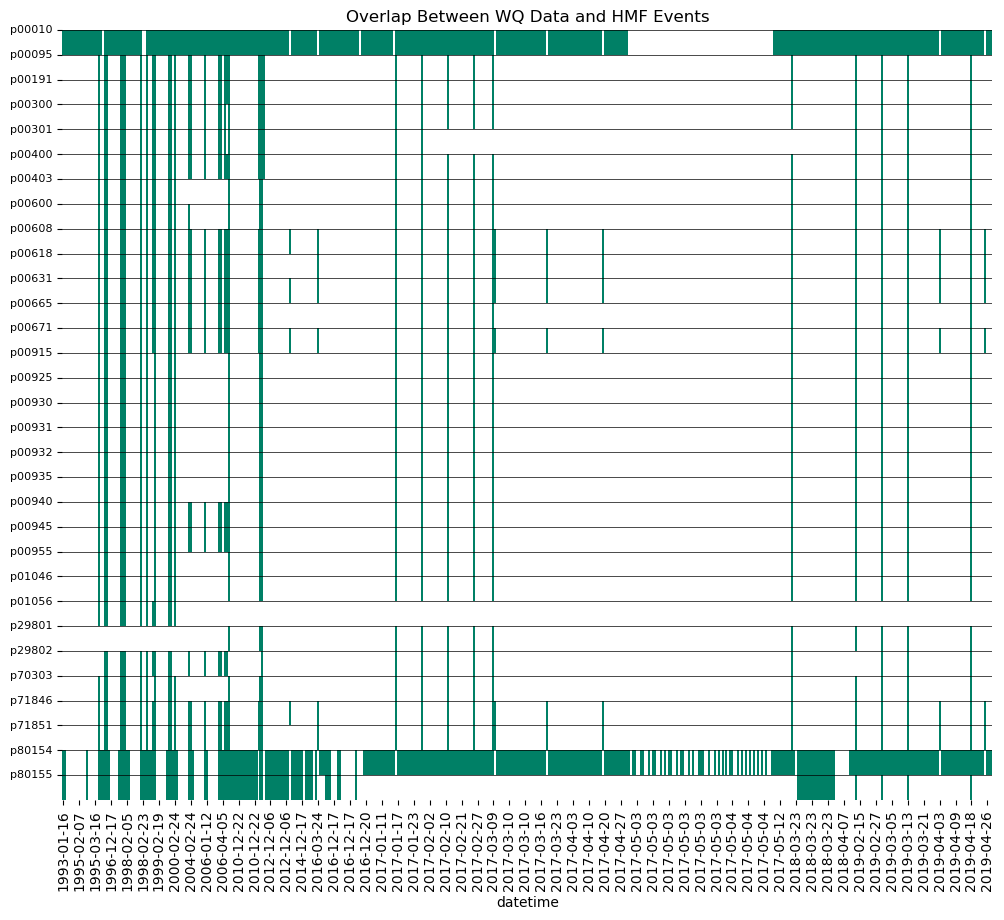

In [15]:
# Only keep columns that are datetime or param codes
# Also set all non-NaN values to 1.0
result_df['datetime'] = pd.to_datetime(result_df['datetime'], errors='coerce')
filtered_df = (result_df.filter(regex='^(datetime|p\d+)', axis=1)
               .set_index('datetime')
               .filter(items=['p' + key for key in fn.WATER_QUALITY_PCODES.keys()]) # Comment this line out if you'd like to see for ALL pCodes
               .applymap(lambda x: 1.0 if pd.notna(x) else x)
               .sort_index(axis=1)
               .sort_index())

# Reformat dateime to just date
filtered_df = filtered_df.reset_index()
filtered_df['datetime'] = filtered_df['datetime'].dt.date
filtered_df.set_index('datetime', inplace=True)
display(filtered_df.tail(1))

plt.figure(figsize=(12, 10))
plt.title('Overlap Between WQ Data and HMF Events')
ax = sns.heatmap(filtered_df.T, cmap='summer', cbar=False)

ax.set_yticks(range(len(filtered_df.columns)))
ax.set_yticklabels(filtered_df.columns, fontsize=8)

plt.grid(True, which='both', axis='y', color='black', linestyle='-', linewidth=0.5)

fig_path = f'water_quality/Saved_Visuals/heatmap_{site}.png'
plt.savefig(fig_path, bbox_inches='tight')

plt.show()



In [9]:
# Filter HMF WQ data for selected pcodes
filtered_df = (result_df.filter(regex='^(datetime|p\d+)', axis=1)
               .set_index('datetime')
               .filter(items=['p' + key for key in fn.WATER_QUALITY_PCODES.keys()]) # Comment this line out if you'd like to see for ALL pCodes
               #.applymap(lambda x: 1.0 if pd.notna(x) else x)
               .sort_index(axis=1)
               .sort_index())

# Filter no HMF WQ data for selected pcodes
result_df_no_hmf = df_wq[~df_wq.index.isin(result_df.index)]

filtered_df_no_hmf = (result_df_no_hmf.filter(regex='^(datetime|p\d+)', axis=1)
               .set_index('datetime')
               .filter(items=['p' + key for key in fn.WATER_QUALITY_PCODES.keys()]) # Comment this line out if you'd like to see for ALL pCodes
               #.applymap(lambda x: 1.0 if pd.notna(x) else x)
               .sort_index(axis=1)
               .sort_index())

# Clean HMF & no HMF WQ data for selected pcodes
def extract_numeric(value):
    """
    Extracts the first numeric value from a string and removes any following text.
    Returns NaN if no valid number is found.
    """
    if isinstance(value, (int, float)):  # If a value is an integer or a float, keep it
        return value
    if isinstance(value, str): # If a value is a string, fix it
        match = re.search(r"[-+]?\d*\.\d+|\d+", value)  # Finds the first numeric value (integer or decimal)
        return float(match.group()) if match else np.nan  # Convert to float or return NaN
    return np.nan  # If not a number or string, return NaN

# Apply to all columns that may contain mixed data
cleaned_df_hmf = filtered_df.apply(lambda col: col.map(extract_numeric))
cleaned_df_no_hmf = filtered_df_no_hmf.apply(lambda col: col.map(extract_numeric))

# # Convert all cleaned columns to float
cleaned_df_hmf = cleaned_df_hmf.astype(float)
cleaned_df_no_hmf = cleaned_df_no_hmf.astype(float)

In [10]:
cleaned_df_no_hmf.columns

Index(['p00010', 'p00095', 'p00191', 'p00300', 'p00301', 'p00400', 'p00403',
       'p00600', 'p00608', 'p00618', 'p00620', 'p00631', 'p00650', 'p00665',
       'p00671', 'p00915', 'p00925', 'p00930', 'p00931', 'p00932', 'p00935',
       'p00940', 'p00945', 'p00955', 'p01046', 'p01056', 'p29801', 'p29802',
       'p70303', 'p71846', 'p71851', 'p80154', 'p80155'],
      dtype='object')

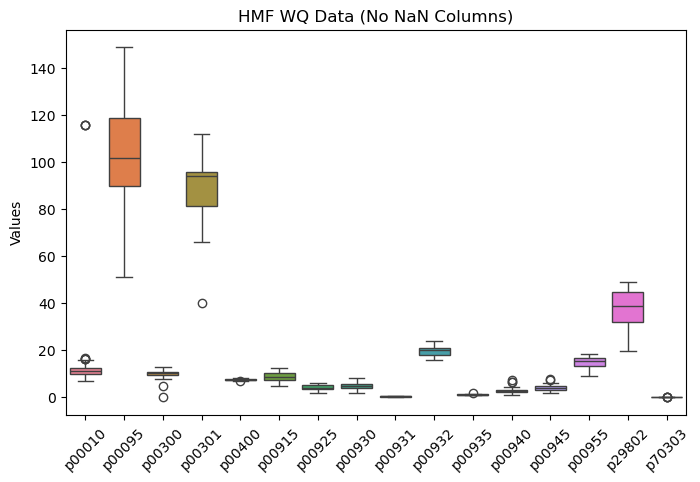

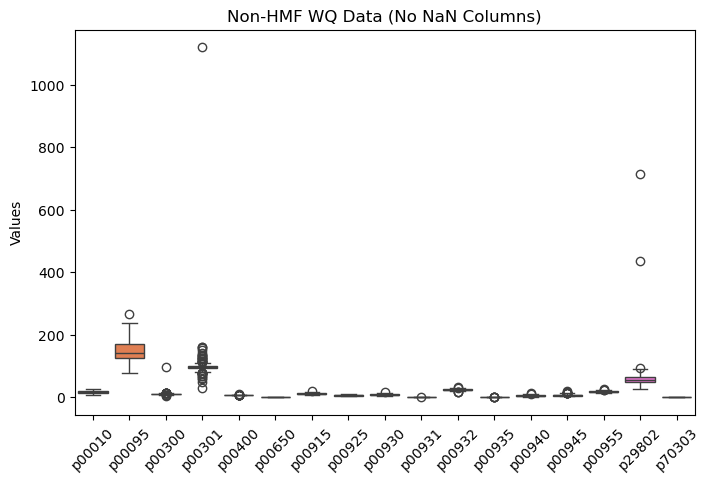

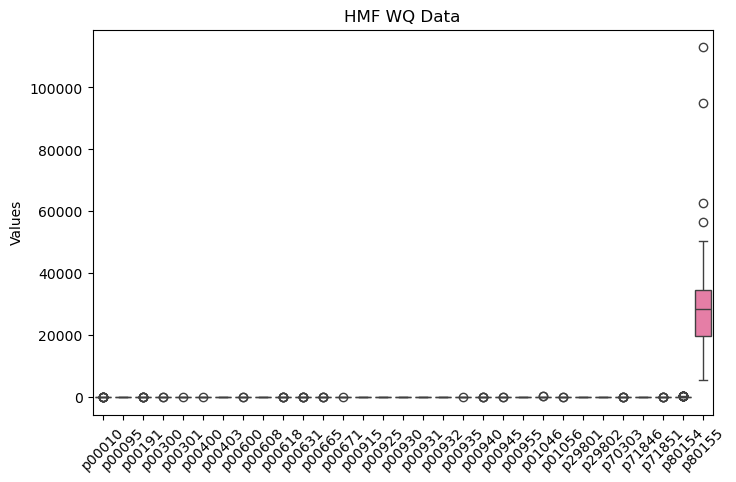

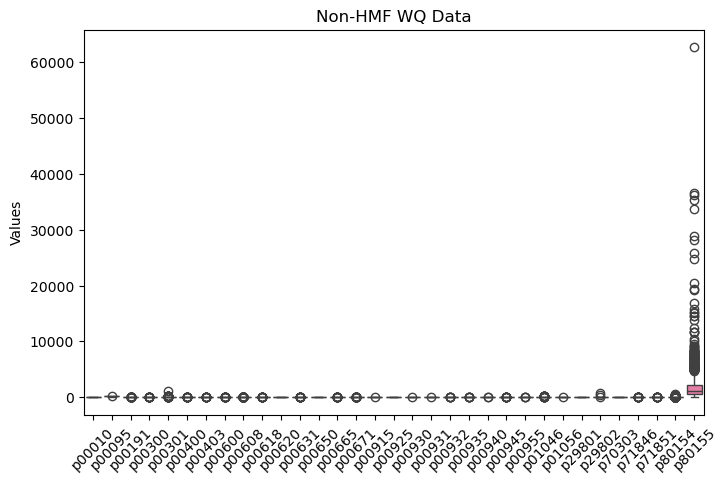

In [11]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=filtered_df)

plt.title("HMF WQ Data (No NaN Columns)")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=filtered_df_no_hmf)

plt.title("Non-HMF WQ Data (No NaN Columns)")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=cleaned_df_hmf)

plt.title("HMF WQ Data")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=cleaned_df_no_hmf)

plt.title("Non-HMF WQ Data")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.show()

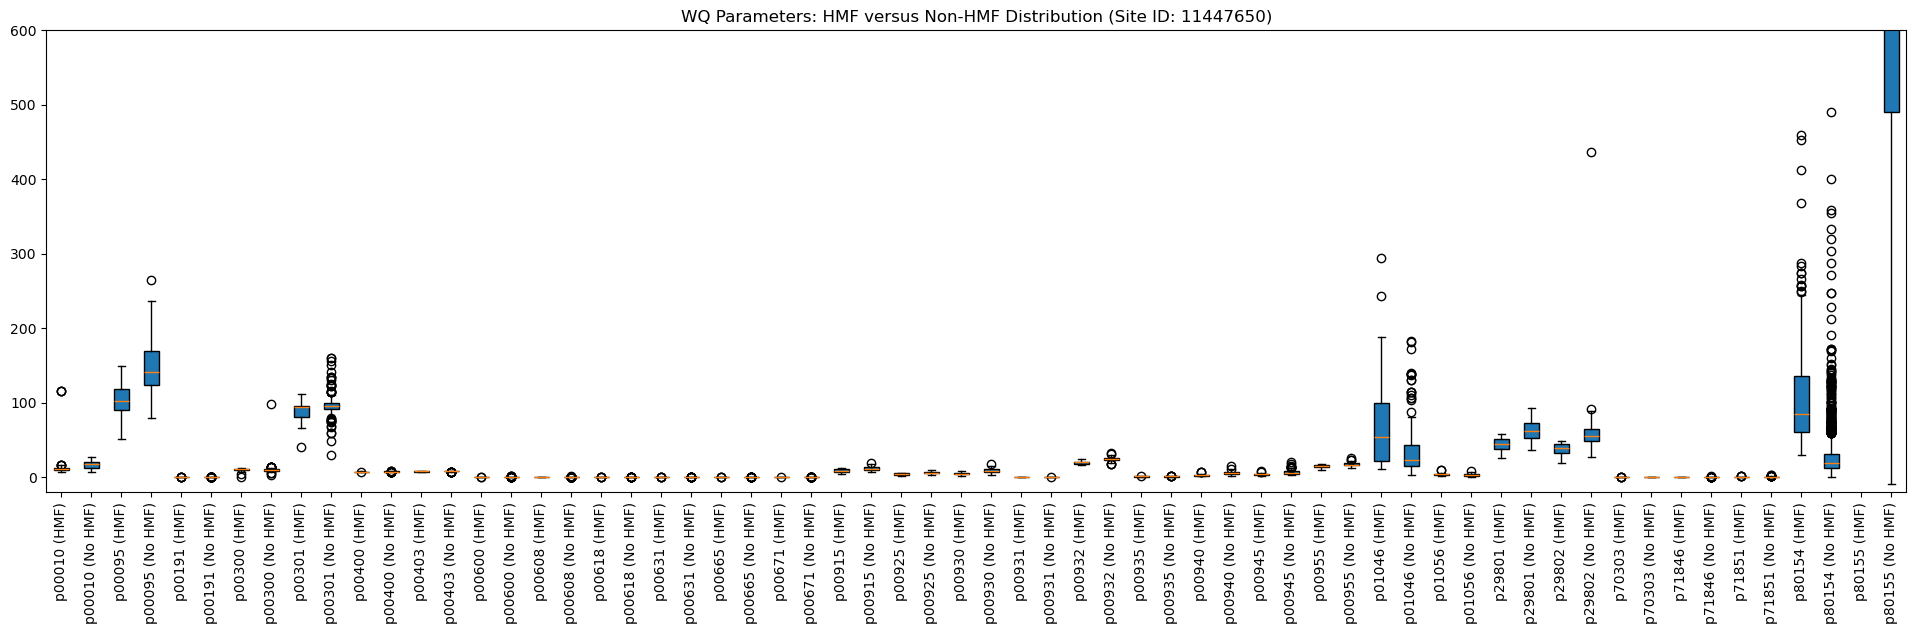

In [14]:
site = '11447650'
columns = filtered_df.columns
boxplot_data = []
labels = []

for col in columns:
    boxplot_data.append(cleaned_df_hmf[col].dropna()) # Create list of lists
    boxplot_data.append(cleaned_df_no_hmf[col].dropna())  
    labels.append(f"{col} (HMF)")
    labels.append(f"{col} (No HMF)")

plt.figure(figsize=(24, 6))
plt.boxplot(boxplot_data, patch_artist=True)
plt.title(f'WQ Parameters: HMF versus Non-HMF Distribution (Site ID: {site})')
plt.xticks(range(1, len(labels)+1), labels, rotation=90)
plt.ylim(-20, 600)

fig_path = f'water_quality/Saved_Visuals/boxplot_comparison_{site}.png'
plt.savefig(fig_path, bbox_inches='tight')

plt.show()